In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytz 
from scipy.optimize import minimize 
import generate_data
import economic_analysis
import optimization
from importlib import reload 



<module 'economic_analysis' from '/Users/Orie4416/Desktop/Feasibility Assessment/code/economic_analysis.py'>

Things I should make classes:
PV Output profile
Battery output profile (has discharge and charge profile characteristics)

## Generate Data

### Simulate charging load and insolation profiles

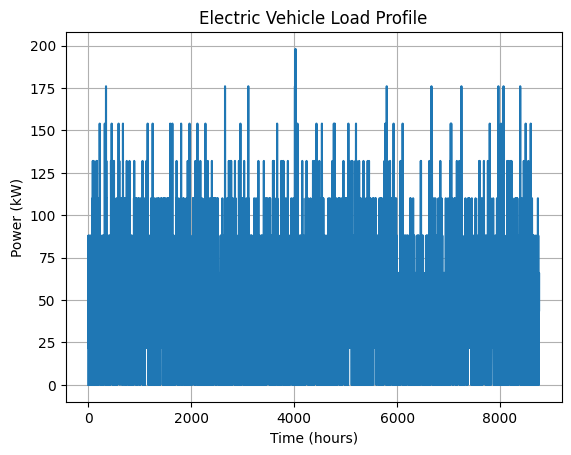

In [2]:
total_days = 365  # Total number of days to simulate
total_time = 24 * total_days  # Total simulation time in hours
time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
num_vehicles = 20  # Number of EVs in the simulation
charging_power = 22  # Charging power in kW (e.g., Level 2 charging)
load_profile = generate_data.simulate_charging_load_profile(total_days, total_time,time_resolution, num_vehicles, charging_power)

/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: overflow encountered in exp
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime


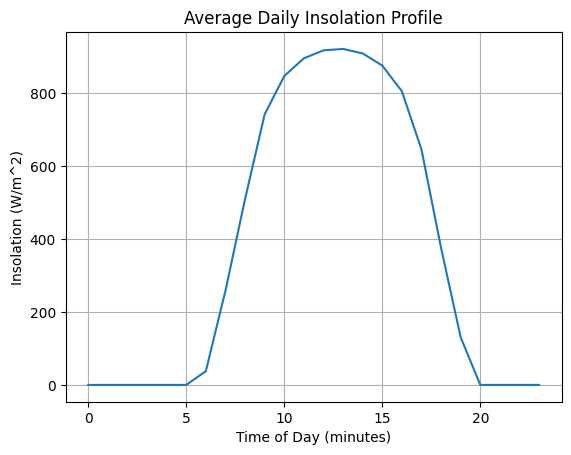

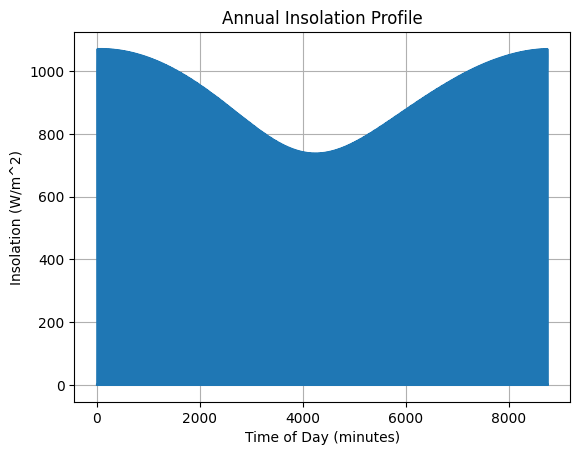

In [3]:
# Location coordinates (latitude, longitude)
latitude = -33.9321  # Stellenbosch, SA
longitude = 18.8602

# Time resolution in minutes
time_resolution = 60

# Set the time zone
timezone = pytz.timezone('Africa/Cairo')  
daily_insolation_profile, annual_insolation_profile = generate_data.simulate_insolation_profile(latitude, longitude, time_resolution, timezone)

### Define input parameters

In [41]:
# Financial market inputs
i_no = 0.0775 # interest rate
f = 0.071 # inflation rate
Rproj = 20 # project lifetime (yrs)
discount_rate = 0.05 # discount rate

# Energy market inputs
feed_in_tariff = 0.05 # $/kWh
flat_energy_usage_cost = 0.20 # $/kWh (unused parameter when using ToD)

# Taxi market inputs
cost_per_passenger = 1 # $/passenger

# Define time periods (in 10-minute increments since midnight)
morning_start = 5  # 5am
afternoon_start = 11  # 11am
evening_start = 16  # 4pm
night_start = 21  # 9pm
time_periods = {'morning_start': morning_start,
                'afternoon_start': afternoon_start,
                'evening_start': evening_start,
                'night_start': night_start}

# Energy costs for different time periods (e.g., morning, afternoon, evening, night)
morning_cost = 0.15  # $/kWh
afternoon_cost = 0.20  # $/kWh
evening_cost = 0.18  # $/kWh
night_cost = 0.12  # $/kWh
time_of_use_tariffs = {'morning': morning_cost,
                       'afternoon': afternoon_cost,
                       'evening': evening_cost,
                       'night': night_cost}

# Values of kWh in terms of passengers for different time periods 
time_passenger_per_kWh = {'morning': 0.66, 
                          'afternoon': 0.33,
                          'evening': 0.66, 
                          'night': 0.25}
# PV system specifications
pv_efficiency = 0.85  # 85% efficiency
pv_m_sq_per_kw = 6 
pv_cost_per_kw = 1000 # $/kW

# Inverter, mounting system, and installation costs
inverter_cost = 1000 # $
mounting_cost = 1000 # $
installation_cost = 1000 # $
additional_pv_capital_cost = inverter_cost + mounting_cost + installation_cost

# Environmental inputs
grid_carbon_intensity = 0.95 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2


# Battery parameters
battery_cost_per_kWh = 500 # $/kWh
battery_charging_efficiency = 0.90
battery_discharging_efficiency = 0.90
battery_duration = 6 # hours 
 

# Station constraints
max_land_area = 1000 # m^2

# System specifications
loadshedding_probability = 3776 / 8760


# a = {
#     'annual_insolation_profile': annual_insolation_profile,
#     'pv_efficiency': pv_efficiency,
#     'load_profile': load_profile,
#     'flat_energy_usage_cost': flat_energy_usage_cost,
#     'Rproj': Rproj,
#     'pv_cost_per_kw': pv_cost_per_kw,
#     'i_no': i_no,
#     'f': f,
#     'discount_rate': discount_rate,
#     'time_of_use_tariffs': time_of_use_tariffs,
#     'time_periods': time_periods,
#     'feed_in_tariff': feed_in_tariff,
#     'battery_cost_per_kWh': battery_cost_per_kWh,
#     'feed_in_tariff_bool': False,
#     'loadshedding_probability': loadshedding_probability,
#     'time_passenger_per_kWh': time_passenger_per_kWh,
#     'cost_per_passenger': cost_per_passenger,
#     'grid_carbon_intensity': grid_carbon_intensity,
#     'carbon_price': carbon_price,
#     'additional_pv_capital_cost': additional_pv_capital_cost,
#     'pv_m_sq_per_kw': pv_m_sq_per_kw,
#     'max_land_area': max_land_area,
#     'max_battery_capacity': 20
# }
a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': flat_energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_duration': battery_duration
}


## Optimization Model

In [47]:
reload(generate_data)
reload(economic_analysis)

reload(optimization)
# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,100), (1,100)]

initial_guess = [20, 20]
##### CUYRRENT ISSUE IS WHEN I AM RUNNING OPTIMIZATION.PY VS THE DIRECT OPTIMIZATION IN FEASIBLITY ANALYSIS I GET DIFF ANSWERS 
### PROCESS TO FIX: REDUCE OBJECTIVE FUNCTION TO MOST BASIC FORM AND THEN BUILD UP TO SEE WHERE ERORR OCCURS
### ALSO THE MODULES DON'T SEEM TO BE IMOPRTING CORRECTLY (ESPECIALLY TO FEASIBLITY.IPYNB)


# Max land area constraint 
#constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 42.07 kW
Optimal battery rating: 72.21 kWh
Maximum NPV : $163205.14
